In [1]:
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import numpy as np
from sklearn.cluster import DBSCAN

In [3]:
import skimage
from skimage import io

import imageio
import scipy
from scipy import ndimage
import random

Text(0.5, 1.0, 'Grass Template')

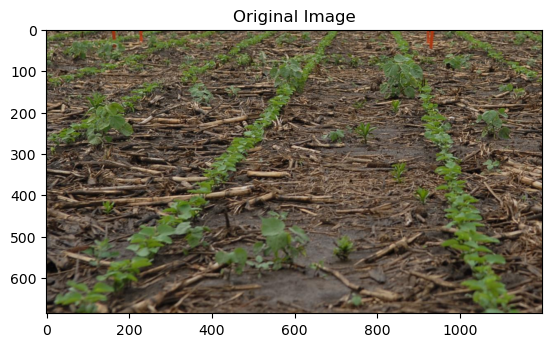

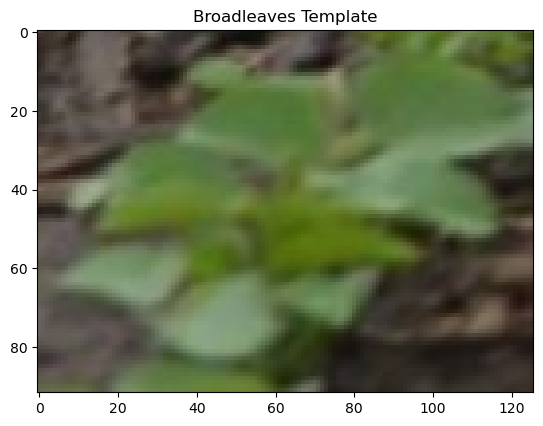

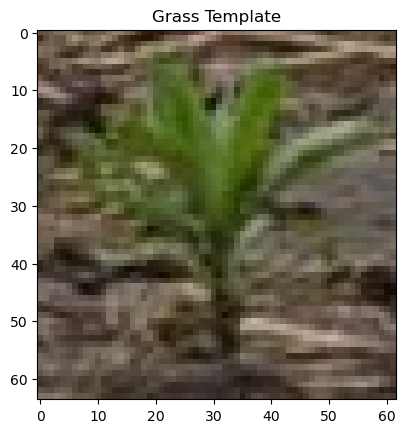

In [11]:
#1

# Load the image using OpenCV
img = cv2.imread('Mod_Pressure.jpg')
broadleaves = cv2.imread('broadleave1.jpg')
broadleaves2 = cv2.imread('broadleave2.jpg')
grass = cv2.imread('grass1.jpg')
grass2 = cv2.imread('grass1.jpg')

# Convert the image to RGB (OpenCV reads images in BGR format)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
broadleaves_temp = cv2.cvtColor(broadleaves, cv2.COLOR_BGR2RGB)
broadleaves_temp2 = cv2.cvtColor(broadleaves2, cv2.COLOR_BGR2RGB)
grass_temp = cv2.cvtColor(grass, cv2.COLOR_BGR2RGB)
grass_temp2 = cv2.cvtColor(grass2, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)
plt.title('Original Image')

plt.figure()
plt.imshow(broadleaves_temp)
plt.title('Broadleaves Template')

plt.figure()
plt.imshow(grass_temp)
plt.title('Grass Template')


In [5]:
#2
weed_type = 2

def ncc(patch, template,n):
    # Compute means
    mean_patch = np.mean(patch,axis=(0,1)) #(1*3)
    mean_template = np.mean(template,axis=(0,1))
    
    # Compute standard deviations
    std_patch = np.std(patch, axis=(0,1), ddof=1)
    std_template = np.std(template,axis=(0,1), ddof=1)
    
    # Compute cross-correlation
    ncc_map = (patch - mean_patch) * (template - mean_template) / (std_patch * std_template) #size of template*3
    #print(ncc_map)
    ncc = np.sum(ncc_map, axis=(0,1,2))/(n-1) #single value
    
    return ncc

def sad(patch, template, n):
    
    #print(np.shape(res))
    return np.sum(np.abs(patch - template)) / n

def ssd(patch, template, n):
    return np.sum((patch - template) ** 2) / n


def template_matching(search_img, template,method):
    # Padding to avoid computing NCC for pixels near the borders
    if template.shape[0]%2 == 0:
        template = template[1:,:,:]
    if template.shape[1]%2 == 0:
        template = template[:,1:,:]
        
    padding_y = template.shape[0] // 2
    padding_x = template.shape[1] // 2
    y = np.shape(template)[0]
    x = np.shape(template)[1]
    n = y*x
    
    # Initialize scores array
    scores = np.zeros((search_img.shape[0] - 2 * padding_y, search_img.shape[1] - 2 * padding_x))
    
    # Iterate through the search image to compute NCC scores
    for i in range(padding_y, search_img.shape[0] - padding_y):
        for j in range(padding_x, search_img.shape[1] - padding_x):
            patch = search_img[i - padding_y:i + padding_y + 1, j - padding_x:j + padding_x + 1]
            #print(np.shape(patch))
            #print(np.shape(template))
            if method == "ncc":
                scores[i - padding_y, j - padding_x] = ncc(patch, template,n)
            elif method == "sad":
                scores[i - padding_y, j - padding_x] = sad(patch, template,n)
            elif method == "ssd":
                scores[i - padding_y, j - padding_x] = ssd(patch, template,n)
    
    return scores



In [6]:

def template_matching_res(template,search_img,method):

    
    # Perform template matching
    scores = template_matching(search_img, template,method)
    
    # Flatten the scores for sorting
    scores_flat = scores.flatten()
    
    # Sort the scores in descending order
    if method == "ncc":
        sorted_indices = np.argsort(scores_flat)[::-1]
    else:
        sorted_indices = np.argsort(scores_flat)
    
    # Plot all sorted scores
    plt.plot(scores_flat[sorted_indices])
    plt.title('Sorted Scores')
    plt.xlabel('Patch Index')
    plt.ylabel('Score')
    plt.show()
    
    # Show patches corresponding to specific indices
    indices_to_show = [0, 1, 4, 9, 99, 499]
    
    for idx in indices_to_show:
        # Get row and column indices of the patch
        row_idx, col_idx = np.unravel_index(sorted_indices[idx], scores.shape)
        
        # Extract the patch from the search image
        patch = search_img[row_idx:row_idx + template.shape[0], col_idx:col_idx + template.shape[1]]
        
        # Display the patch
        plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        plt.title(f'Patch {idx+1} (Score: {scores_flat[sorted_indices[idx]]})')
        plt.axis('off')
        plt.show()


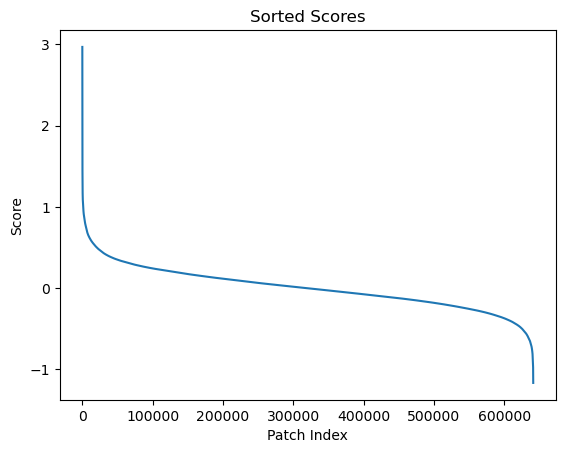

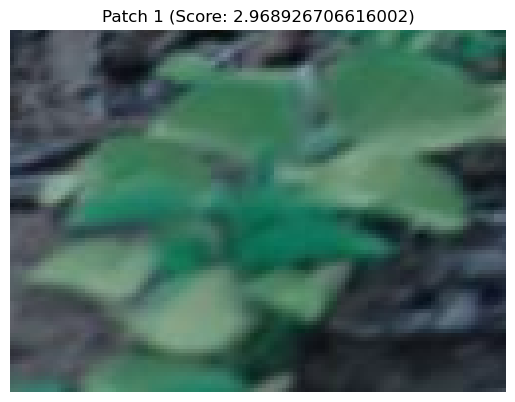

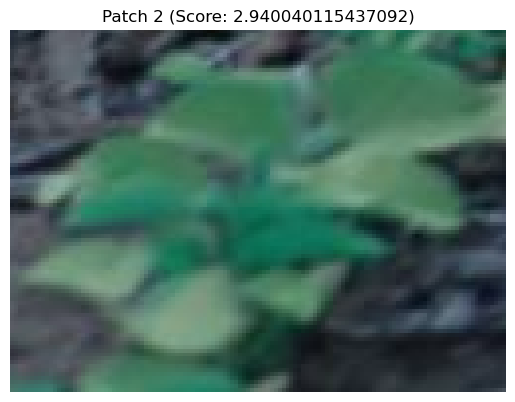

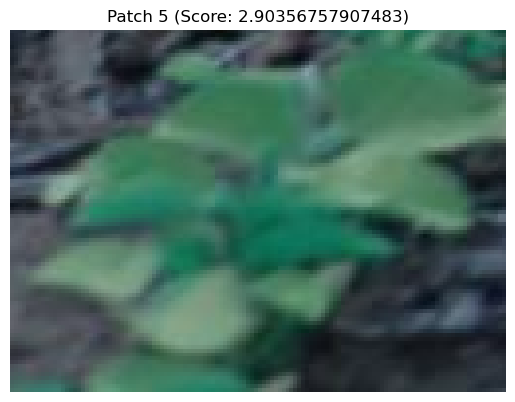

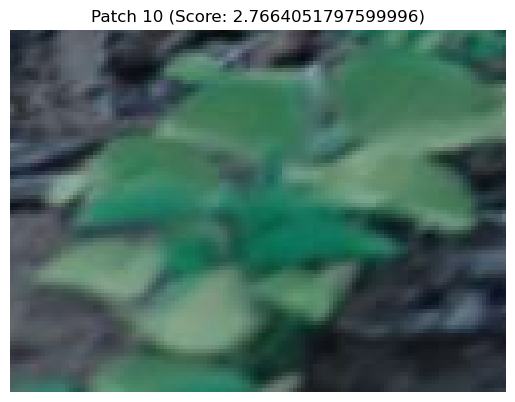

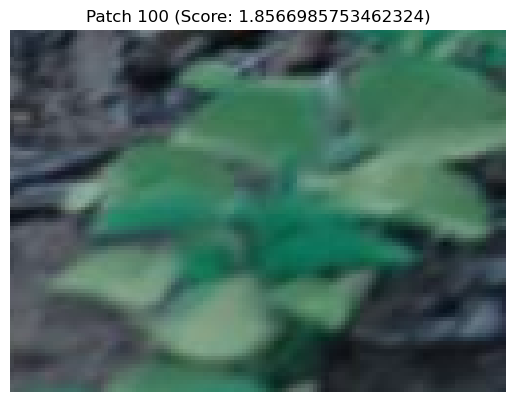

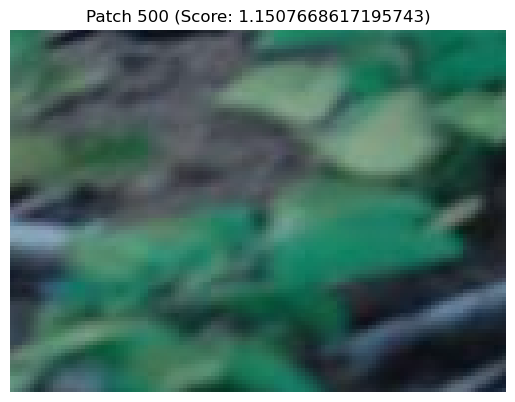

In [7]:
template_matching_res(broadleaves_temp,img,'ncc')


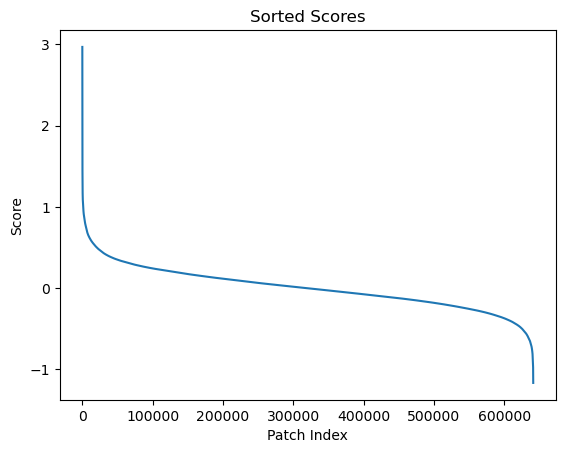

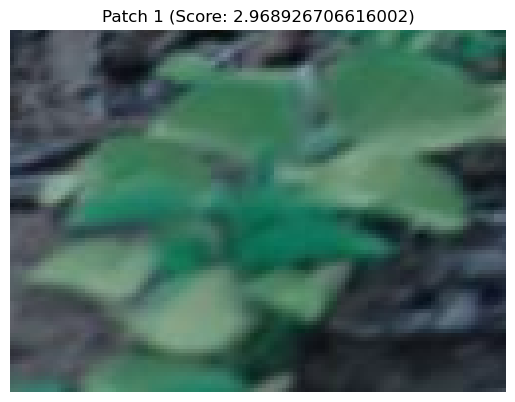

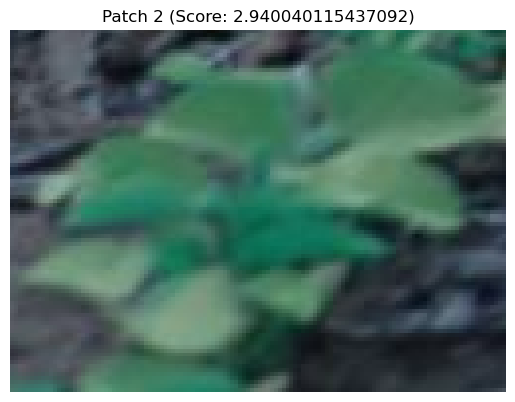

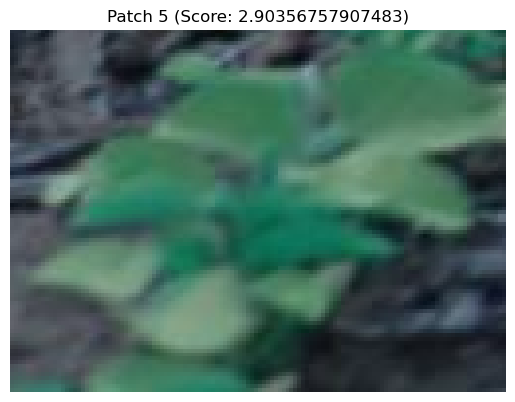

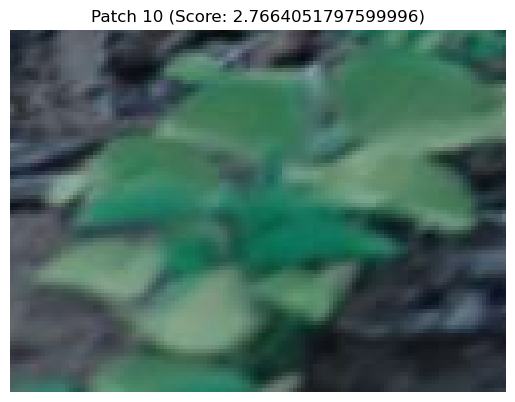

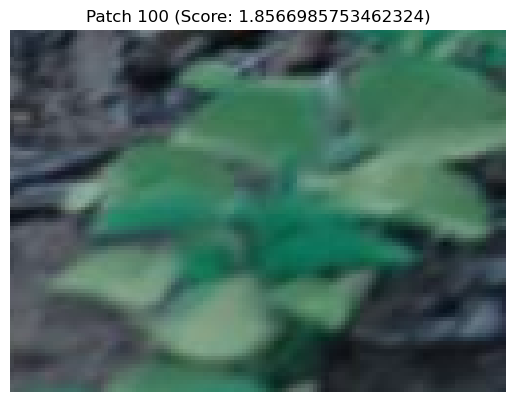

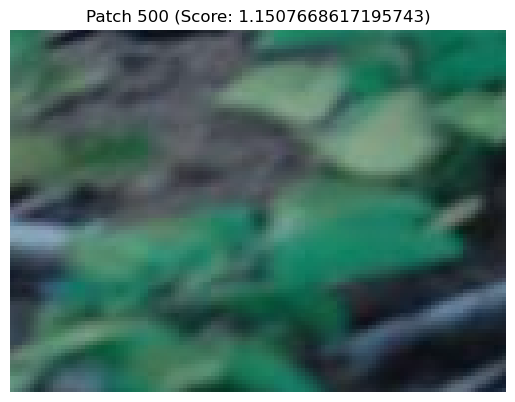

In [10]:
template_matching_res(broadleaves_temp2,img,'ncc')

In [12]:
template_matching_res(grass_temp2,img,'ncc')

KeyboardInterrupt: 

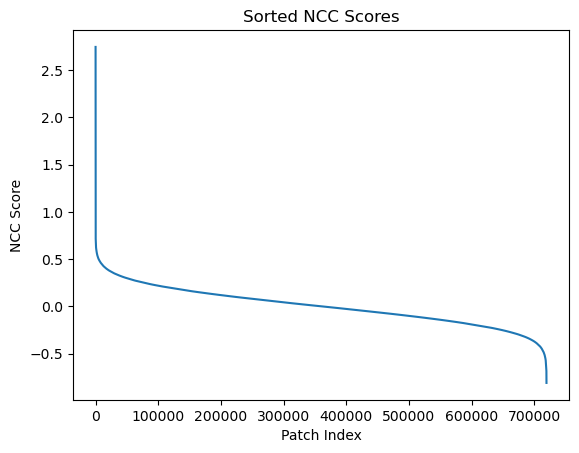

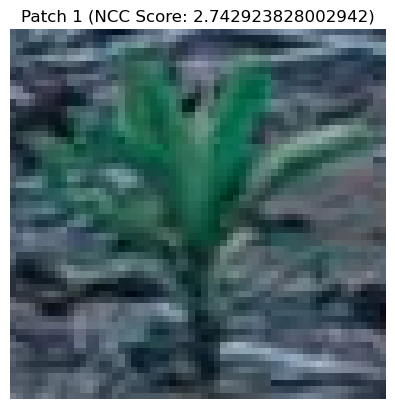

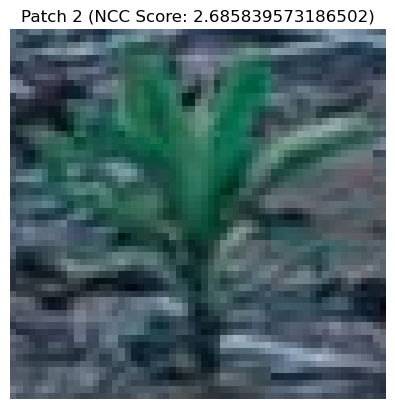

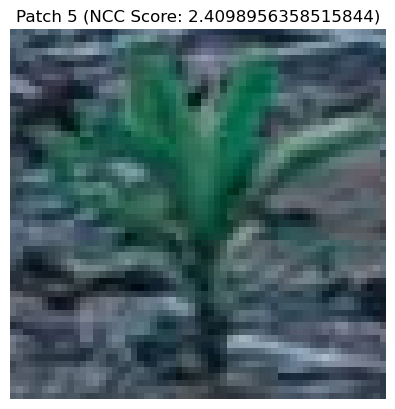

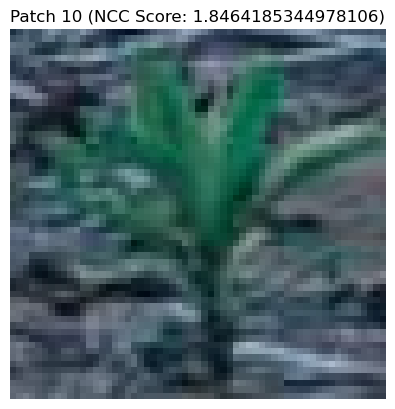

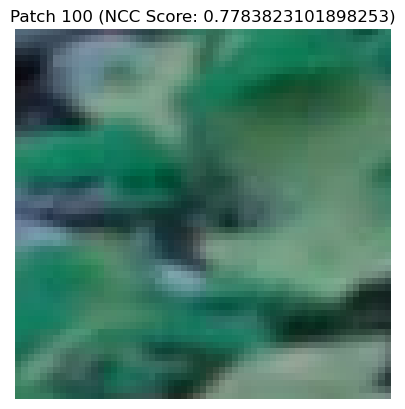

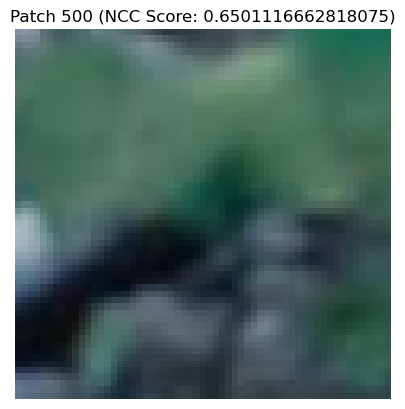

In [20]:
template_matching_res(grass_temp,img,'ncc')

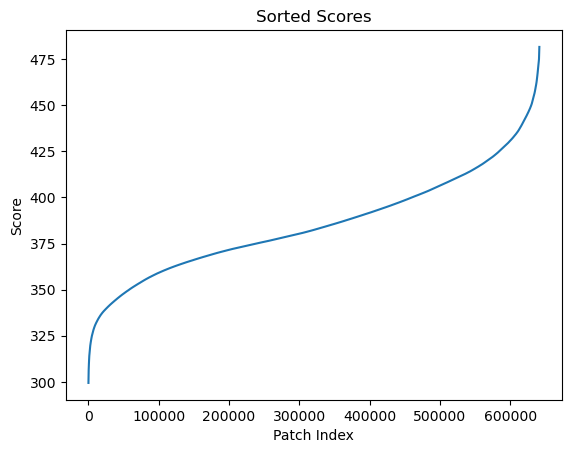

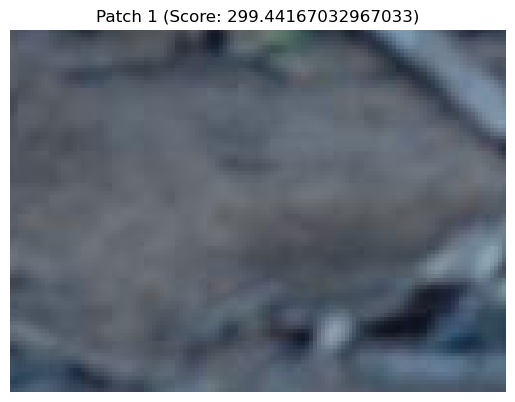

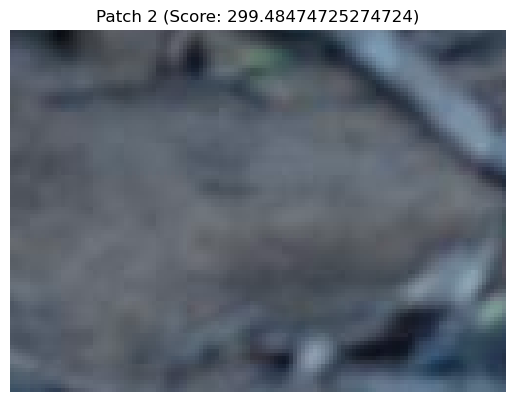

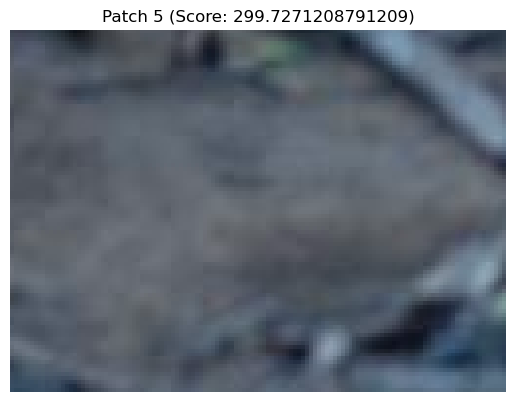

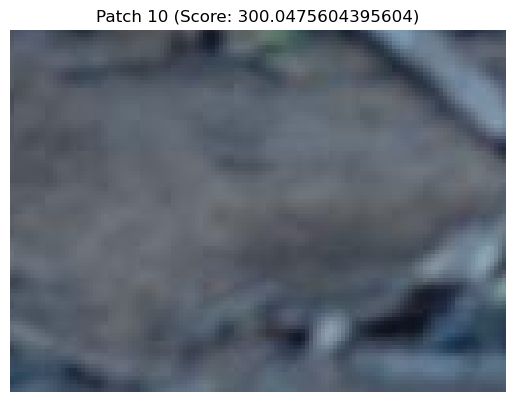

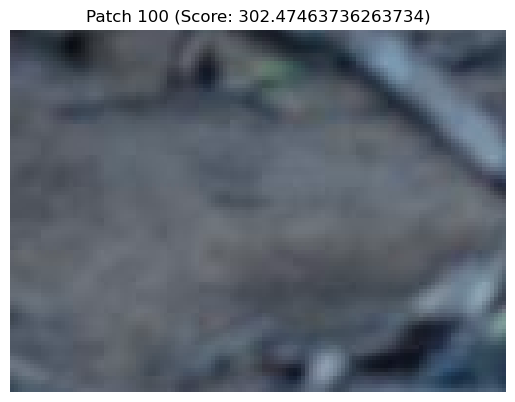

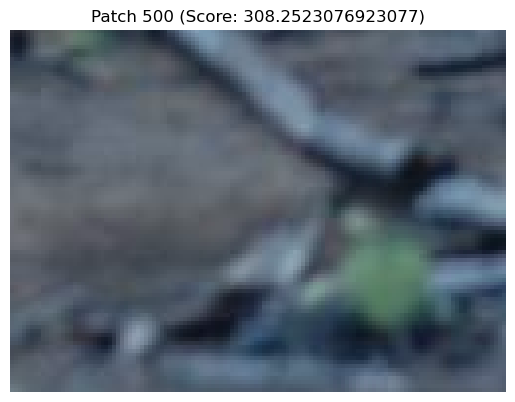

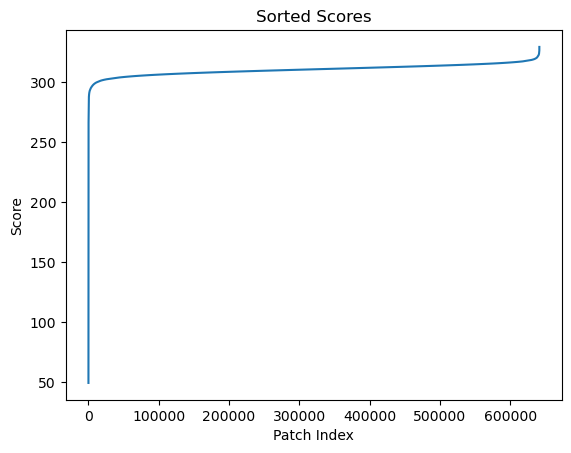

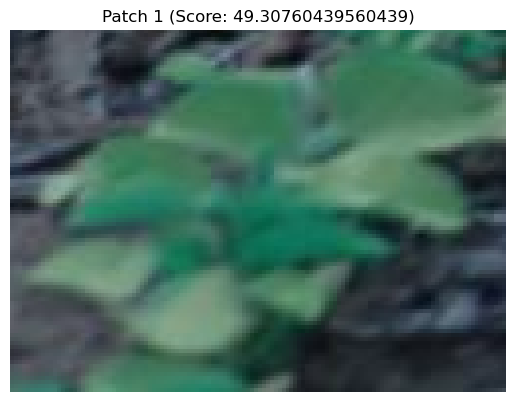

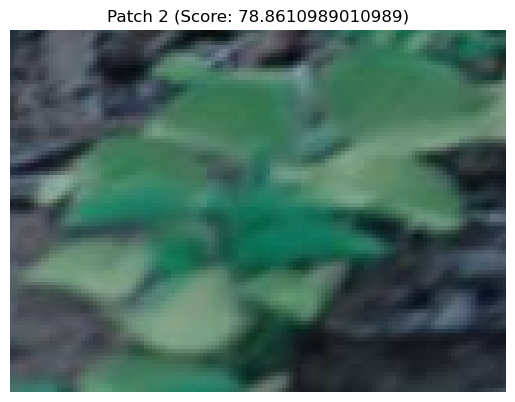

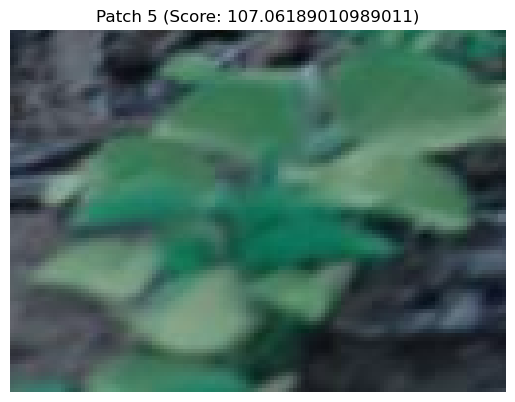

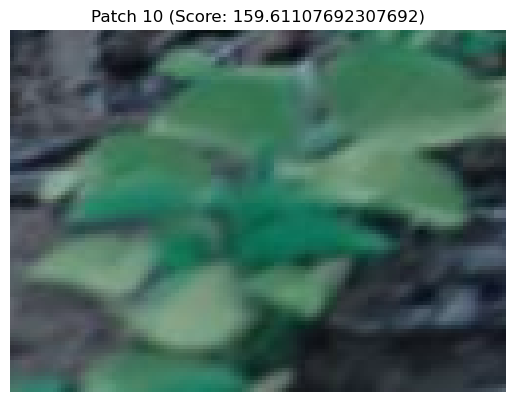

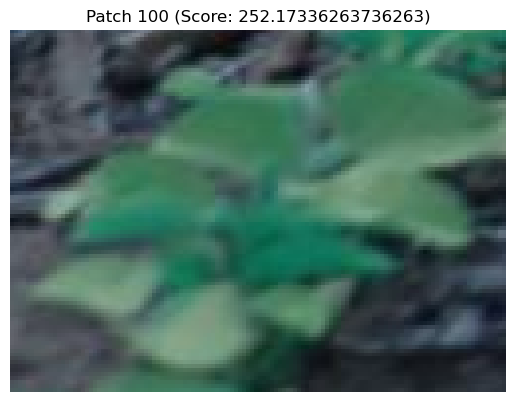

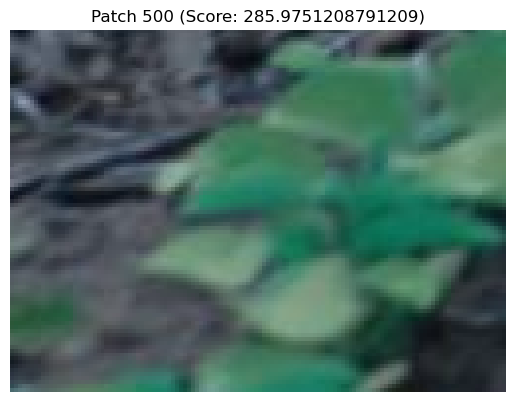

In [13]:
template_matching_res(broadleaves_temp,img,'sad')
template_matching_res(broadleaves_temp,img,'ssd')

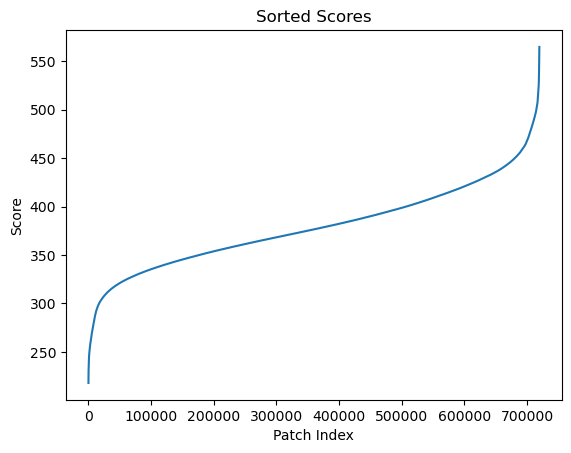

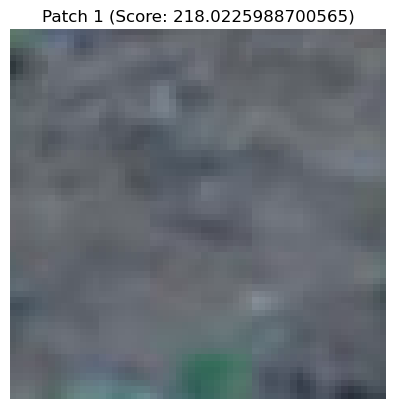

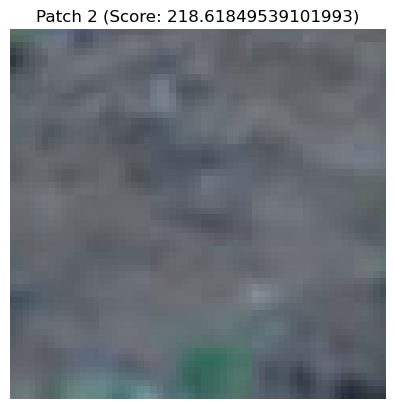

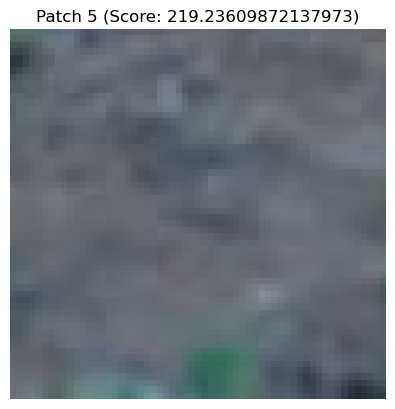

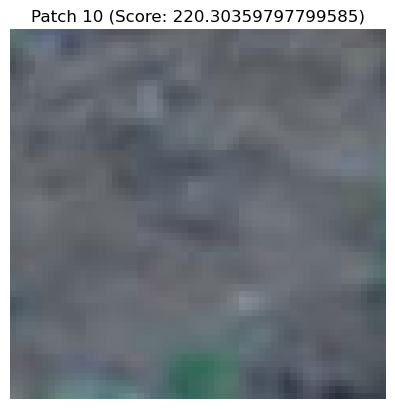

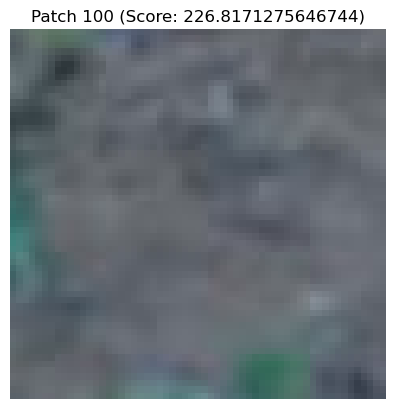

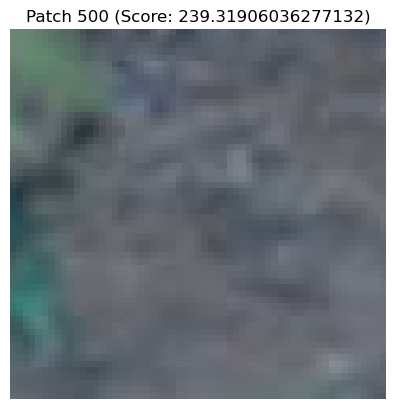

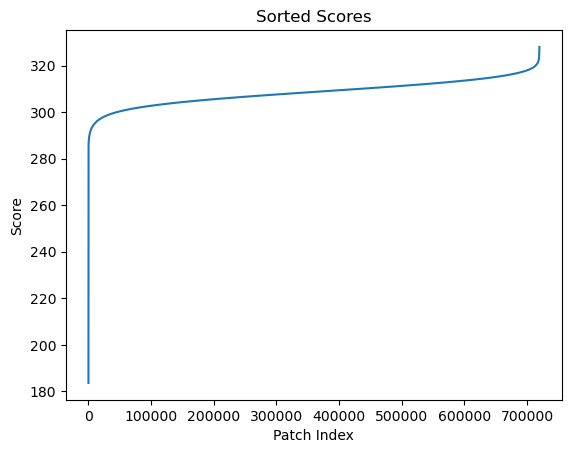

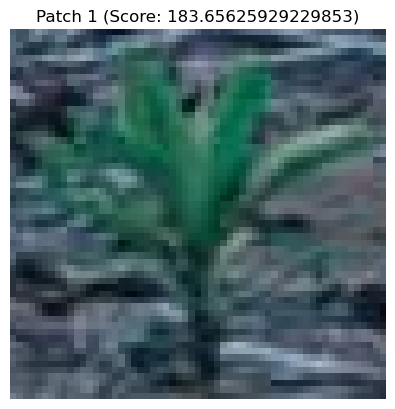

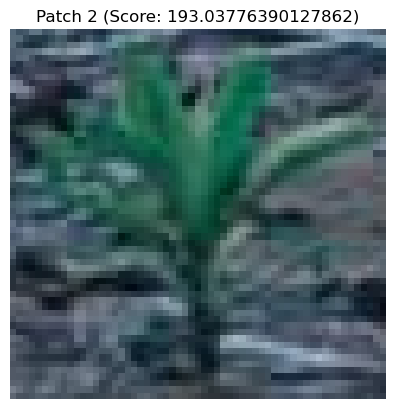

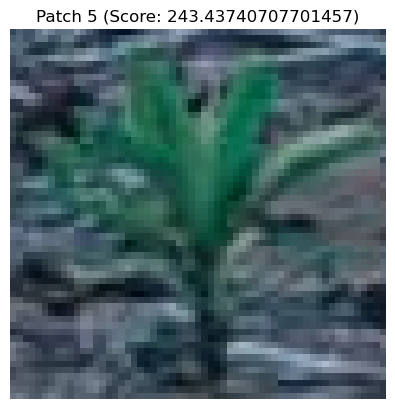

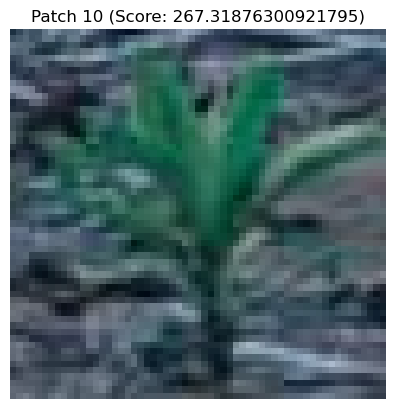

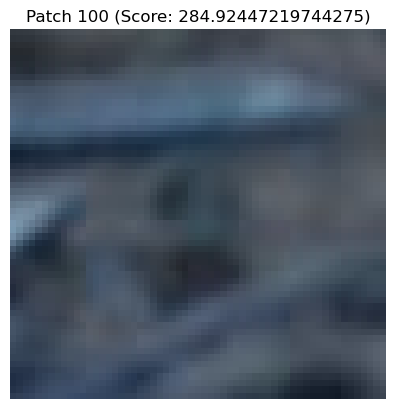

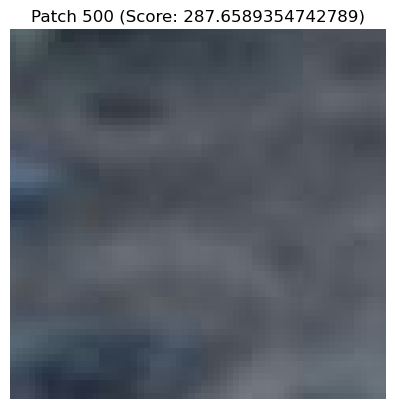

In [16]:
template_matching_res(grass_temp,img,'sad')
template_matching_res(grass_temp,img,'ssd')

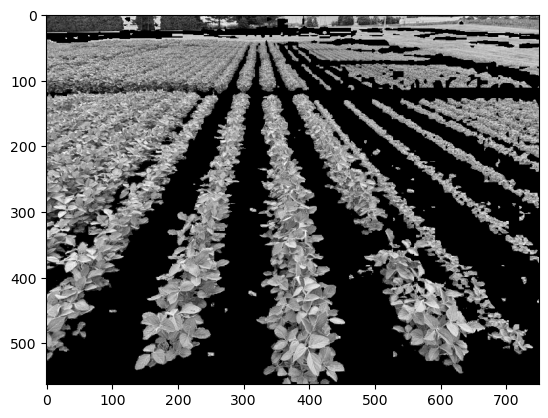

In [11]:
img= io.imread('MSU.jpg')
img_g=img[:, :, 1]
img_r=img[:,:,0]
img_new=img_r*0
r,c=img_r.shape
for i in range(r):
    for j in range(c):
        if img_g[i,j]>img_r[i,j]:
            img_new[i,j]=img_g[i,j]
            
        else:
            img_new[i,j]=0
plt.imshow(img_new,cmap='grey')  
filt_img=img_new

filt_img=filt_img[150:500,100:550] #350*450

In [15]:
print(np.shape(filt_img))

(350, 450)


In [28]:
n = 0
#while(n<4):
labimg = cv2.pyrDown(filt_img)  #pyramid
    #n = n+1
#labimg = filt_img

feature_image=np.reshape(labimg, [-1, 1])
rows, cols = labimg.shape

db = DBSCAN(eps=12, min_samples=50, metric = 'euclidean',algorithm ='auto') #euclidean distance
db.fit(feature_image)
labels = db.labels_

xycolors = np.zeros((rows,cols,3))
indices = np.dstack(np.indices(labimg.shape[:2])) #将列表中的数组沿深度方向进行拼接 （0，1）

xycolors[:,:,0:2] = indices
xycolors[:,:,2] = labimg
print(np.shape(indices))
print(np.shape(xycolors))



(175, 225, 2)
(175, 225, 3)


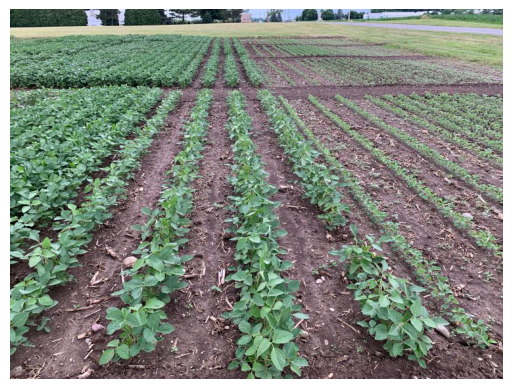

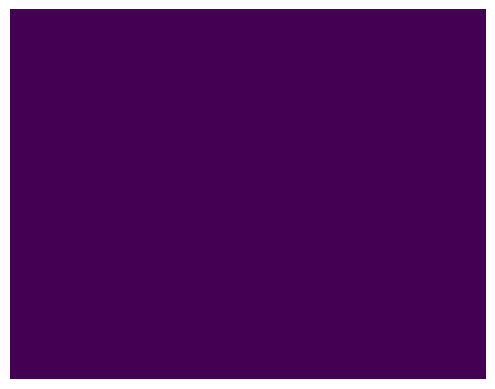

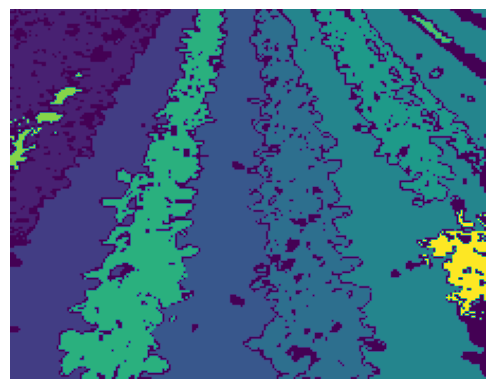

In [35]:
feature_image2 = np.reshape(xycolors, [-1,3])
db.fit(feature_image2)
labels2 = db.labels_

plt.figure()
plt.imshow(img)
plt.axis('off')

plt.figure()
plt.imshow(np.reshape(labels, [rows, cols]))
plt.axis('off')

plt.figure()
labels2 = np.reshape(labels2, [rows, cols])
plt.imshow(labels2)
plt.axis('off')
plt.show()

In [36]:
dic = {}
for i in range(rows):
    for j in range(cols):
        d_label = labels2[i,j]
        if d_label not in dic.keys():
            dic[d_label] = 1
        else:
            dic[d_label] += 1
print(dic)

{0: 3153, -1: 5882, 1: 4921, 6: 4415, 2: 5421, 3: 4888, 4: 7673, 5: 2175, 7: 52, 8: 182, 9: 18, 10: 595}


In [24]:
#print(np.shape(labimg))
#print(np.shape(indices))
print(np.shape(xycolors[:,:] ))
175*255

(175, 225, 3)


44625